# Exploratory Data Analysis

In [5]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html{font-size: 18px; line-height: 1.4}</style>"))

In [6]:
Housing_data = pd.read_csv('cleaned_1.csv')
Housing_data = Housing_data.set_index(['parcelid','Unnamed: 1'])
del Housing_data['garagetotalsqft'] # this has a very large amount of missing data, so will be excluded for now
Housing_data['transactiondate'] = pd.to_datetime(Housing_data['transactiondate'], 
                                                 format = '%Y-%m-%d', errors = 'coerce')
Housing_data['yearbuilt'] = pd.to_datetime(Housing_data['yearbuilt'], format='%Y.0', errors='coerce').dt.year
Housing_data['assessmentyear'] = pd.to_datetime(Housing_data['assessmentyear'], 
                                                format='%Y-%m-%d', errors='coerce').dt.year
Housing_data['taxdelinquencyyear'] = pd.to_datetime(Housing_data['taxdelinquencyyear'], 
                                                    format='%Y-%m-%d', errors='coerce').dt.year
smallhousedf = Housing_data.drop(['taxdelinquencyyear'], axis = 1)
smallhousedf = smallhousedf.dropna()
smallhousedf=smallhousedf[smallhousedf['finishedsquarefeet12'] <= 10000]
smallhousedf['yearbuiltint'] = smallhousedf['yearbuilt'].astype(int)

<IPython.core.display.Javascript object>


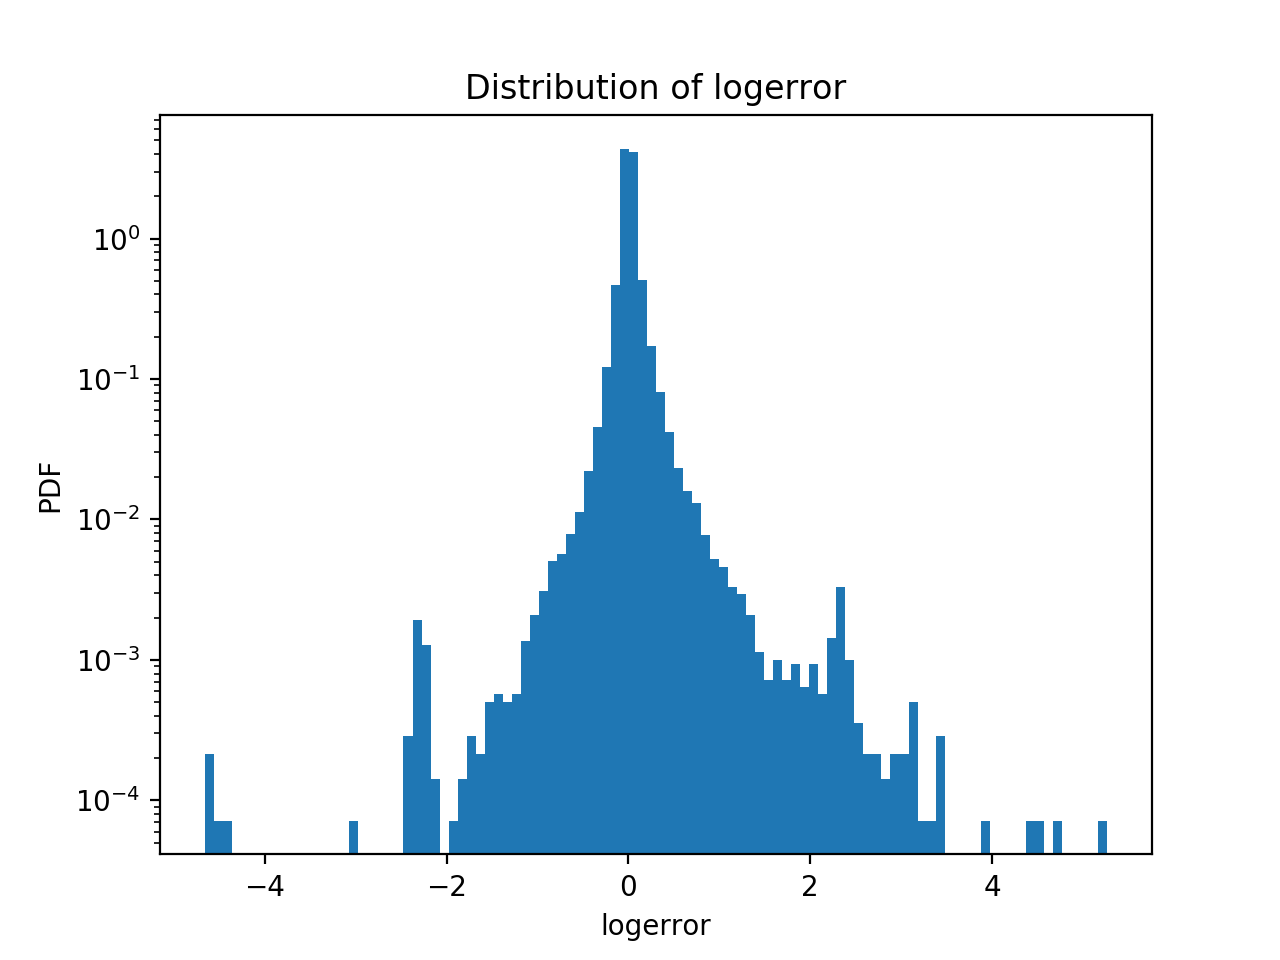

In [17]:
fig = plt.figure()
_ = plt.hist(smallhousedf['logerror'], bins=100, density='normal')
_ = plt.yscale('log')
_ = plt.xlabel('logerror')
_ = plt.ylabel('PDF')
_ = plt.title('Distribution of logerror')

## Part 1: Curious features.

Earlier we saw two clusters of entries whose logerror was around $\pm 2$, seen in the above histogram. We also identified 9 features which seemed to help identify them them. We will call these sig_cols.

In [8]:
sig_cols = ['yearbuiltint','fips', 'regionidcity', 'pooltypeid', 'latitude',
            'longitude', 'rawcensustractandblock', 'regionidcounty', 'regionidzip']

We want to see if our earlier visual observations bear up to statistical testing. We can first look at raw correllative values, but we know from before that they have weak correllation. 

In [9]:
for col in sig_cols:
    correl = smallhousedf[col].corr(smallhousedf['logerror'])
    print('Correlation for',col+':', correl)

Correlation for yearbuiltint: 0.018088868440040203
Correlation for fips: 0.00919708382138304
Correlation for regionidcity: 0.001260861020584775
Correlation for pooltypeid: -0.012614974571508656
Correlation for latitude: -0.009518340401136909
Correlation for longitude: 0.011934297721691673
Correlation for rawcensustractandblock: 0.009161837232164686
Correlation for regionidcounty: -0.014906174007484821
Correlation for regionidzip: -0.002905383840025018


So instead we will perform a test similar to the one from the Hospital readmission project. Where we compare the distributions of two different portions of the entires based on their values from sig_cols. Before we do that we must first find out where we must seperate each feature. We will do this by looking at the colour spectrums we used to find these features in Data_Storytelling notebook. However, many of these are quite small and dont have an associated legend. So these visualizations are redrawn in Colour_visualizations notebook.

In [15]:
year_cutoff = 2000
fips_cutoff = 6045
city_cutoff = 40000
pool_cutoff = 3
lati_cutoff = 34184400
long_cutoff = -118255700
census_cutoff = 60500320
county_cutoff = 1600
zip_cutoff = 96600
sig_cutoffs = [year_cutoff, fips_cutoff, city_cutoff, pool_cutoff,lati_cutoff, long_cutoff,
              census_cutoff, county_cutoff, zip_cutoff]

For each feature in sig_cols, we set up the following (generalized) hypothesis.'

### $H_0 =$ Real estate transations whose specified feature is less than the cutoff has the same distribution as those greater than the cutoff.

### $H_A = $ Real estate transations whose specified feature is less than the cutoff has a different distribution as those greater than the cutoff.

We use the difference of means as our test statistic. First we observe some histograms. We set them to log scale so we can observe the clusters. In these histograms we note that the blue histogram has much more pronounced clusers.

<IPython.core.display.Javascript object>


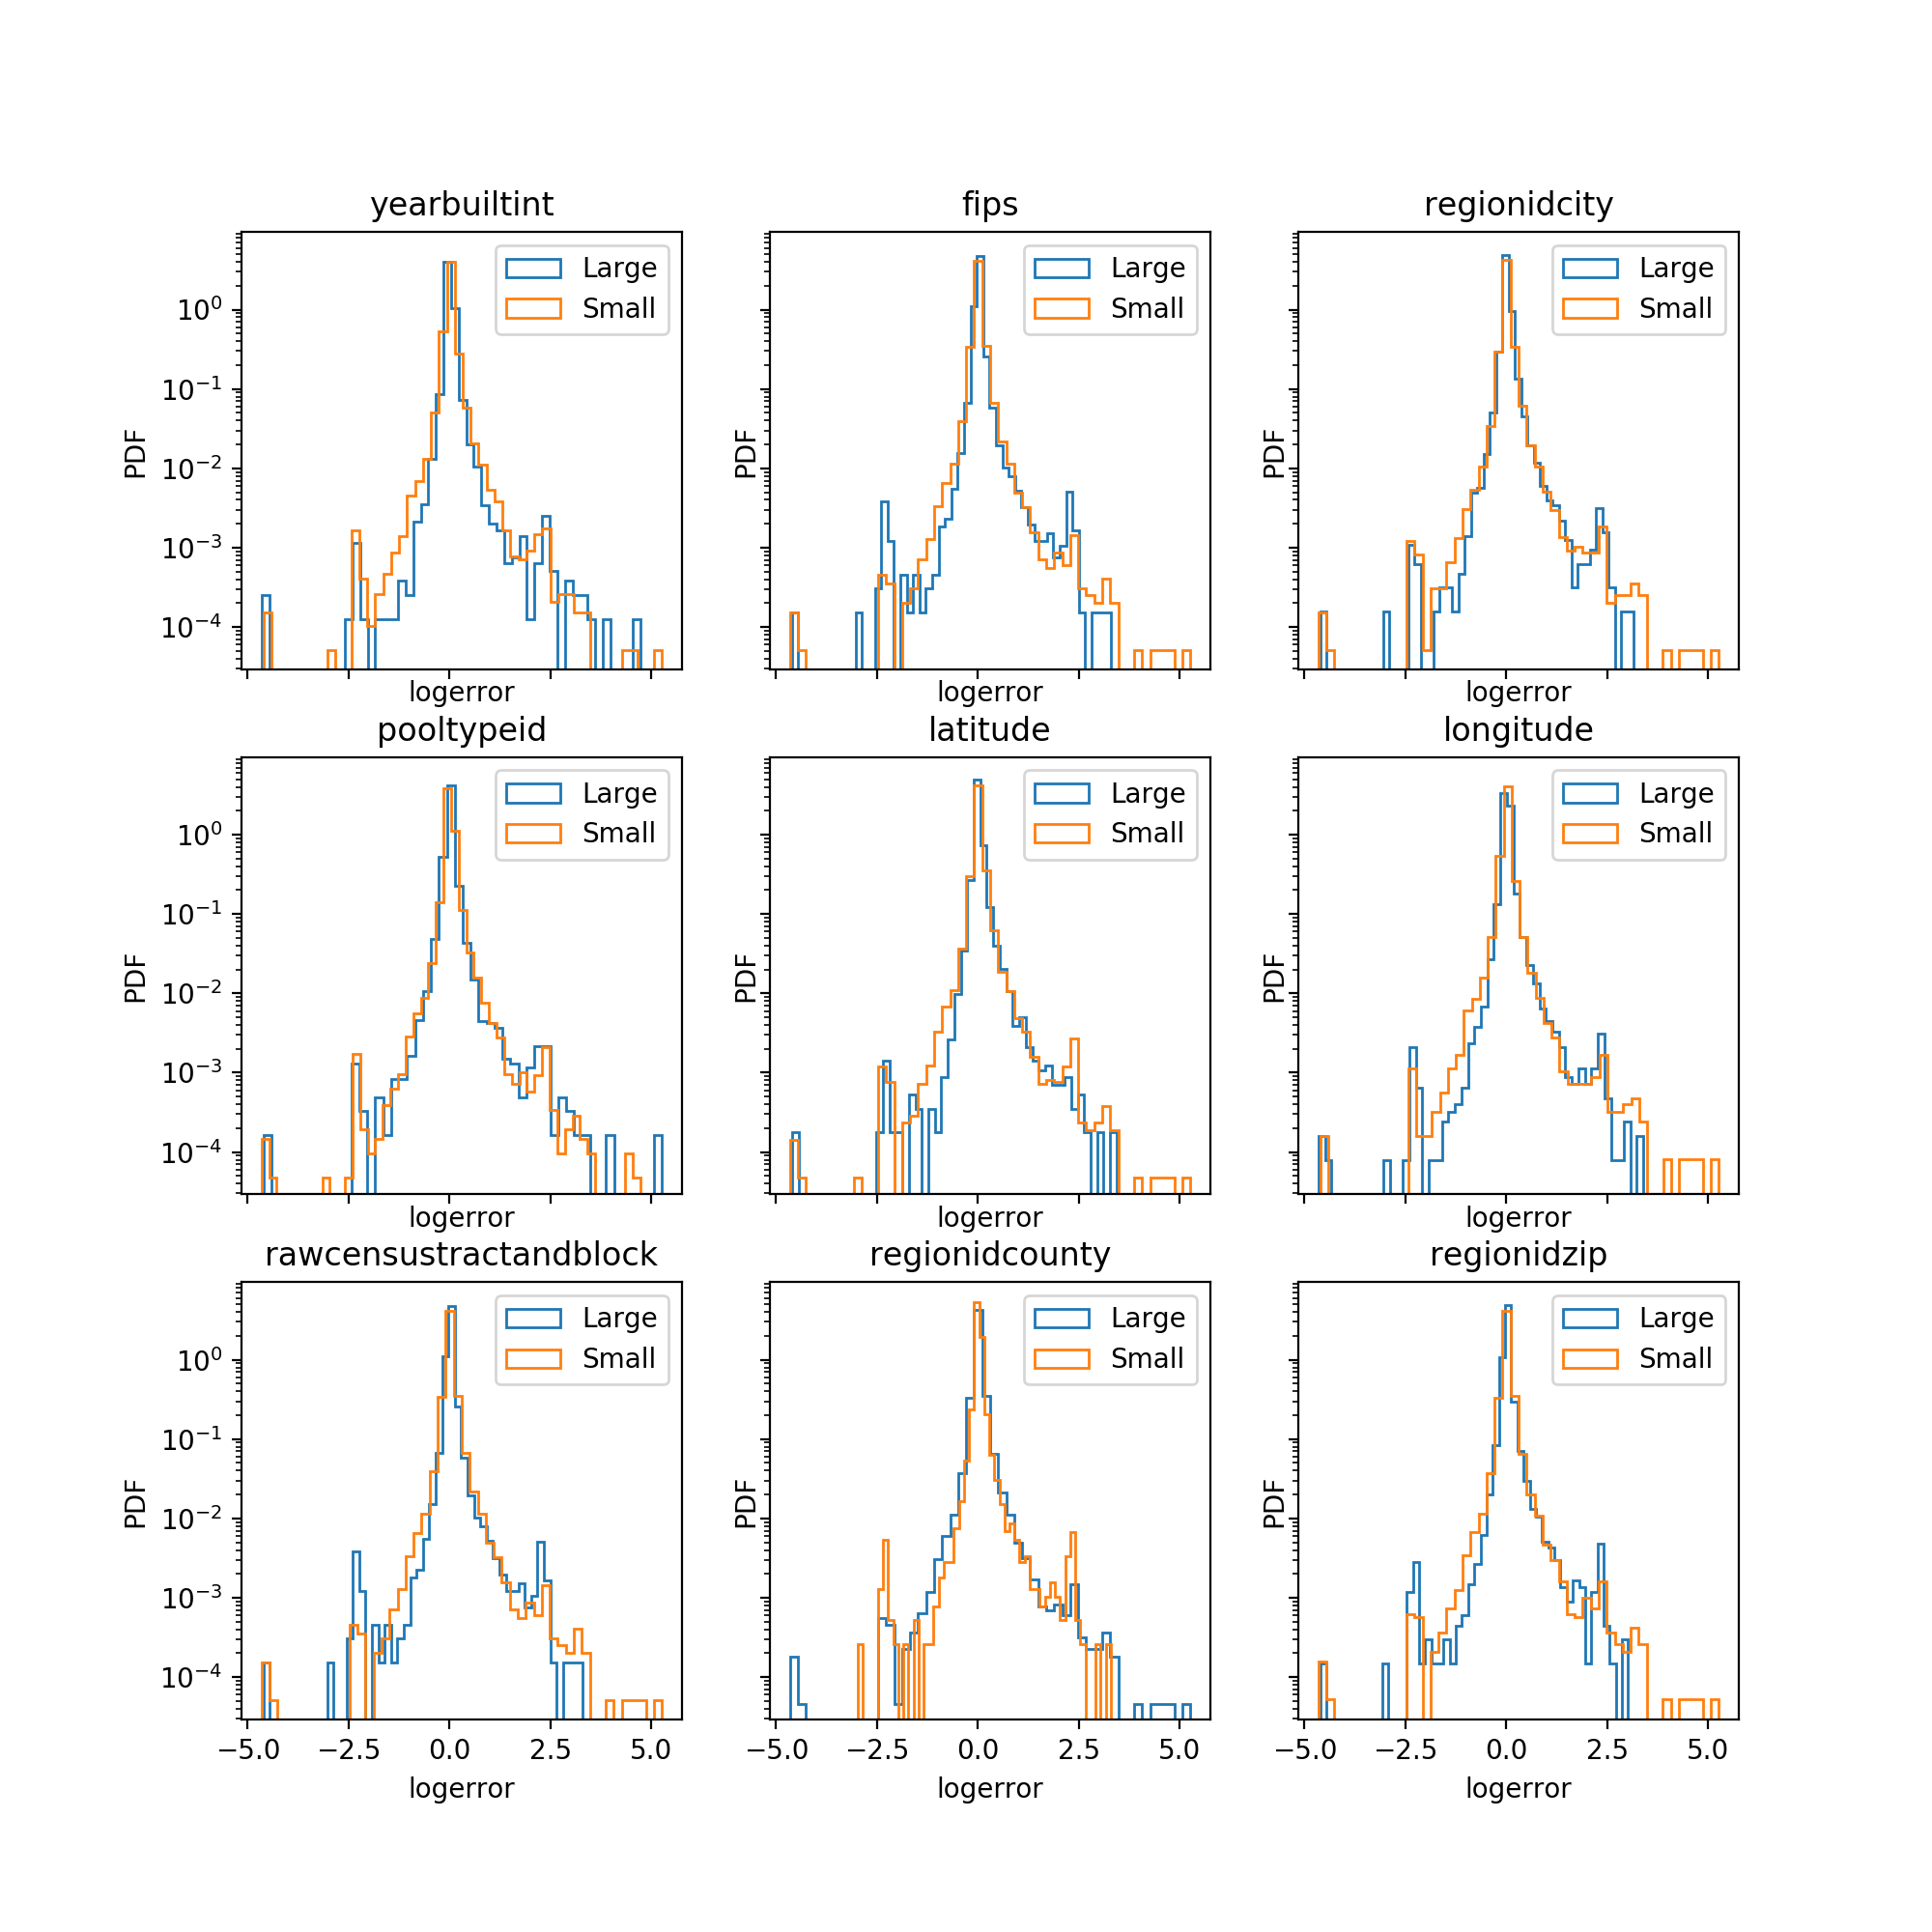

In [16]:
fig, ((ex1,ex2,ex3), (ex4,ex5,ex6), (ex7,ex8,ex9)) = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
# plot the linear_data on the 5th subplot axes 

exs = [ex1,ex2,ex3,ex4,ex5,ex6,ex7,ex8,ex9]

for n in range(0, len(exs)):
    df = smallhousedf[[sig_cols[n], 'logerror']]
    large_df = df[df[sig_cols[n]] > sig_cutoffs[n]]
    small_df = df[df[sig_cols[n]] <= sig_cutoffs[n]]
    exs[n].hist(large_df['logerror'], bins=50, density=True, histtype='step')
    exs[n].hist(small_df['logerror'], bins=50, density=True, histtype='step')
    #exs[n].set_xlim([-3.5,3.5])
    exs[n].set_yscale('log')
    exs[n].set_xlabel('logerror')
    exs[n].set_ylabel('PDF')
    exs[n].set_title(sig_cols[n])
    exs[n].legend(('Large','Small'))

In [13]:
bs_num = 10000

def diff_of_means(data_1, data_2):
    return np.mean(data_1) - np.mean(data_2)

for i in range(len(sig_cols)):
    print('statistics for',sig_cols[i], 'with cutoff of', sig_cutoffs[i])
    df = smallhousedf[[sig_cols[i], 'logerror']]
    large_df = df[df[sig_cols[i]] > sig_cutoffs[i]]
    small_df = df[df[sig_cols[i]] <= sig_cutoffs[i]]
    diff_obs = diff_of_means(large_df[sig_cols[i]], small_df[sig_cols[i]])
    
    print('the observed difference is: ',diff_obs)
    both_conc = np.concatenate((large_df[sig_cols[i]], small_df[sig_cols[i]]))
    
    bs_replicates = np.empty(bs_num)
    p_list = np.empty(len(sig_cols))
    
    for j in range(bs_num):
        bs_sample = np.random.choice(both_conc, size=len(both_conc))
        bs_replicates[j] = diff_of_means(bs_sample[:len(small_df[sig_cols[i]])],
                                         bs_sample[len(small_df[sig_cols[i]]):])
        
    p = np.sum(abs(bs_replicates) >= abs(diff_obs)) / len(bs_replicates)
    p_list[i] = p
    print('p-value =', p)
    print('')

statistics for yearbuiltint with cutoff of 2000
the observed difference is:  41.18433765266013
p-value = 0.0

statistics for fips with cutoff of 6050
the observed difference is:  35.489941907916545
p-value = 0.0

statistics for regionidcity with cutoff of 40000
the observed difference is:  51385.75041441979
p-value = 0.0

statistics for pooltypeid with cutoff of 3
the observed difference is:  4.944831527951663
p-value = 0.0

statistics for latitude with cutoff of 34184400
the observed difference is:  435112.3159861192
p-value = 0.0

statistics for longitude with cutoff of -118255700
the observed difference is:  557044.1021978259
p-value = 0.0

statistics for rawcensustractandblock with cutoff of 60500320
the observed difference is:  350784.3402251601
p-value = 0.0

statistics for regionidcounty with cutoff of 1600
the observed difference is:  1712.9351428908726
p-value = 0.0

statistics for regionidzip with cutoff of 96600
the observed difference is:  977.117654286878
p-value = 0.0



In [14]:
for i in range(len(sig_cols)):
    if p_list[i] < 0.05:
        print('The feature', sig_cols[i], 'has different distributions for values above and below', sig_cutoffs[i])
    else:
        print('The feature', sig_cols[i], 'has similar distributes for values above and below', sig_cutoffs[i])
    print('')

The feature yearbuiltint has different distributions for values above and below 2000

The feature fips has different distributions for values above and below 6050

The feature regionidcity has different distributions for values above and below 40000

The feature pooltypeid has different distributions for values above and below 3

The feature latitude has different distributions for values above and below 34184400

The feature longitude has different distributions for values above and below -118255700

The feature rawcensustractandblock has different distributions for values above and below 60500320

The feature regionidcounty has different distributions for values above and below 1600

The feature regionidzip has different distributions for values above and below 96600



### Conclusions

All the $p$ values we found were zero. This means that in $10,000$ trials, not a single trial produced distributions as different as the ones we observed. Confirming, empirically, our observations made in the Data Storytelling notebook.